__(a)__ To increase computational efficiency, we were asked to manipulate the pixel values of input images and extract intensity and symmetry features. <br>

Intensity is simply looking at the value of the elements of our image vector, and if it is greater than 0, it is counted as black pixel, and if it is less than 0, it is counted as white pixel. Accordingly, we took the number of black pixels as the intensity feature.  <br>

We defined the symmetry feature as the negative of the sum of the absolute values of the difference of the elements corresponding to the same position after making the given vector two-dimensional and taking its symmetry with respect to the y-axis. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

train_size = 1561
test_size = 424
image_length = 256

X_train = np.load("train_data.npy")
y_train = np.load("train_labels.npy")

X_test = np.load("test_data.npy")
y_test = np.load("test_labels.npy")


def extract_features(X, data_size):
    X_ext = np.zeros(shape=(data_size, 3))
    
    # setting the X[:, 0] = 1 in order to absorb the bias term w[0]
    X_ext[:, 0] = 1
    
    # extracting intensity (amount of black pixels)
    for i in range(data_size):
        black_pixels = 0
        for j in range(image_length):
            if X[i][j] > 0:
                black_pixels += 1
        
        X_ext[i][1] = black_pixels
    
    # extracting symmetry (negative of absolute difference between an image and its flipped versions)
    for i in range(data_size):
        asymmetry = 0
        for row in range(16):
            for col in range(8):
                asymmetry += abs(X[i][16*row+col] - X[i][16*row+15-col])
                
        X_ext[i][2] = -asymmetry
        
    
    return X_ext


In [2]:
X_train_ext = extract_features(X_train, train_size)
X_test_ext = extract_features(X_test, test_size)

In [3]:
def plot_features(X, y, data_size):
    for i in range(data_size):
        # digit 1
        if y[i] == 1:
            plt.scatter(X[i][1], X[i][2], color = 'b', marker = 'o')
            
        # digit 5
        elif y[i] == -1:
            plt.scatter(X[i][1], X[i][2], color = 'r', marker = 'x')
        
    plt.xlabel("intensity")
    plt.ylabel("symmetry")
            

__(b)__ You can find the plots of the training and test data below. Blue data points correspond to digit 1 and red data points correspond to digit 5.

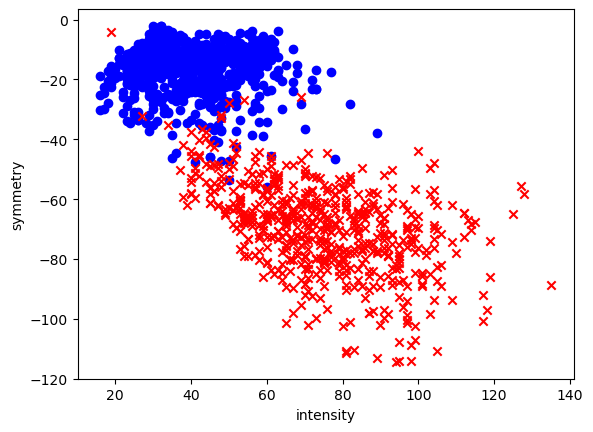

In [4]:
# plotting features of the extracted train data
# o: digit 1
# x: digit 5
plot_features(X_train_ext, y_train, train_size)

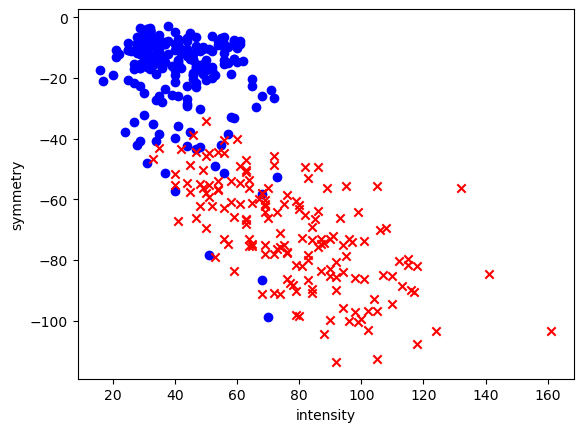

In [5]:
# plotting features of the extracted test data
# o: digit 1
# x: digit 5
plot_features(X_test_ext, y_test, test_size)

__(c)__ The logistic loss function is defined as $ E(\mathbf w) = \dfrac{1}{N} \displaystyle\sum_{i=1}^N \ln(1+e^{-y_{i}w^\intercal x_{i}}). $ Now, let's take the gradient. 

$ \nabla_{w} E(\mathbf w) = \nabla\dfrac{1}{N} \displaystyle\sum_{i=1}^N \ln(1+e^{-y_{i}w^\intercal x_{i}}) $

$= \dfrac{1}{N} \displaystyle\sum_{i=1}^N \nabla\ln(1+e^{-y_{i}w^\intercal x_{i}})$

$ = \dfrac{1}{N} \displaystyle\sum_{i=1}^N  \dfrac{-y_{i}x_{i} e^{-y_{i}w^\intercal x_{i}}}{1 + e^{-y_{i}w^\intercal x_{i}}} $

$ = \dfrac{1}{N} \displaystyle\sum_{i=1}^N -y_{i}x_{i} \sigma(-y_{i}w^\intercal x_{i})$


In our implementation, we used the version we derivated in the last step above. 

In [6]:
def sigmoid(y, w, x):
    a = y * np.dot(w, x)
    s = 1 / (1 + math.exp(-a))
    return s


def gradient(y, w, X, data_size):
    gradient = 0
    for i in range(data_size):
        gradient -= y[i] * X[i] * sigmoid(-y[i], w, X[i])
        
    gradient /= data_size
    return gradient


def logistic_regression(y, X, data_size, feature_no, learning_rate, iterations):
    # w[0] is the bias term
    w = np.zeros(feature_no+1)
    
    for i in range(iterations):
        g = gradient(y, w, X, data_size)
        w = w - learning_rate * g
        
    return w


In [7]:
# applying logistic regression to find coefficients that will approximately minimize the error
w_ext = logistic_regression(y_train, X_train_ext, train_size, 2, 0.1, 5000)

print(f"Weight vector is: {w_ext}")

Weight vector is: [22.8462141  -0.0926886   0.40482195]


__(c)__ We trained our model using 0.1 learning rate and 5000 iterations. In the plot, it can be seen that the decision boundary separated the data almost perfectly. We derived the formula for the decision boundary as follows: <br>
$ \sigma (\mathbf w^\intercal \mathbf x) = \dfrac{1}{2} \Longrightarrow  \mathbf w^\intercal \mathbf x = 0 \Longrightarrow w_{0} + w_{1}x_{1} + w_{2}x_{2} = 0 \Longrightarrow x_{2} = -\dfrac{w_{1}}{w_{2}}x_{1} - \dfrac{w_{0}}{w_{2}}$ <br>
Here $ x_{2} $ represents the symmetry and $ x_{1} $ represents the intensity.

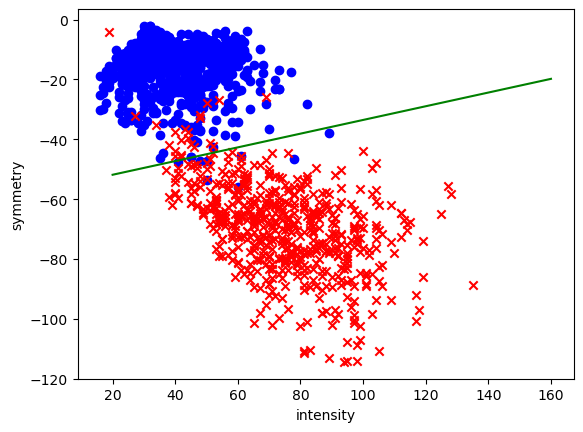

In [8]:
g = lambda x : -w_ext[1]*x/w_ext[2] - w_ext[0]/w_ext[2]
x_axis, y_axis = [20, 160], [g(20), g(160)]

# plotting features of the extracted train data with the separator
plot_features(X_train_ext, y_train, train_size)
plt.plot(x_axis, y_axis, color = 'green')
plt.show()

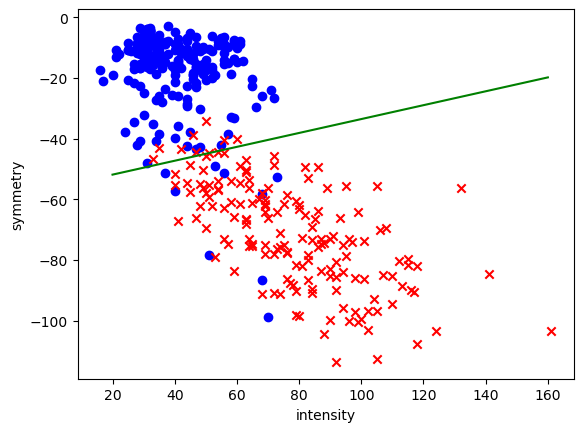

In [9]:
# plotting features of the extracted test data with the separator
plot_features(X_test_ext, y_test, test_size)
plt.plot(x_axis, y_axis, color = 'green')
plt.show()

In [10]:
def calculate_error(y, w, X, data_size):
    error = 0
    for i in range(data_size):
        s = y[i] * np.dot(w, X[i]) 
        error += np.log(1 + math.exp(-s))
    
    error /= data_size
    return error

def calculate_accuracy(y, w, X, data_size):
    correct = 0
    for i in range(data_size):
        if y[i] * np.dot(w, X[i]) > 0:
            correct += 1
    
    return 100 * correct / data_size
            
    

print(f"Train error is {calculate_error(y_train, w_ext, X_train_ext, train_size)}")
print(f"Test error is {calculate_error(y_test, w_ext, X_test_ext, test_size)}")

print(f"Train accuracy is % {calculate_accuracy(y_train, w_ext, X_train_ext, train_size)}")
print(f"Test accuracy is % {calculate_accuracy(y_test, w_ext, X_test_ext, test_size)}")
    

Train error is 0.07783669203816104
Test error is 0.2379474377060314
Train accuracy is % 98.0140935297886
Test accuracy is % 95.75471698113208


__(d)__ The logistic loss function with regularization is defined as $ E(\mathbf w) = \dfrac{1}{N} \displaystyle\sum_{i=1}^N \ln(1+e^{-y_{i}w^\intercal x_{i}} + \mathbf{\lambda w^\intercal w}). $ Now, let's take the gradient. 

$ \nabla_{w} E(\mathbf w) = \nabla\dfrac{1}{N} \displaystyle\sum_{i=1}^N \ln(1+e^{-y_{i}w^\intercal x_{i}}) + 2\mathbf{\lambda w} $

$= \dfrac{1}{N} \displaystyle\sum_{i=1}^N \nabla\ln(1+e^{-y_{i}w^\intercal x_{i}}) + 2\mathbf{\lambda w} $

$ = \dfrac{1}{N} \displaystyle\sum_{i=1}^N  \dfrac{-y_{i}x_{i} e^{-y_{i}w^\intercal x_{i}}}{1 + e^{-y_{i}w^\intercal x_{i}}} + 2\mathbf{\lambda w} $

$ = \dfrac{1}{N} \displaystyle\sum_{i=1}^N -y_{i}x_{i} \sigma(-y_{i}w^\intercal x_{i}) + 2\mathbf{\lambda w} $

In our implementation for the regularized gradient, we used the version we derivated in the last step above and updated the logistic regression with the regularization accordingly. 

In [11]:
def gradient_with_regularization(y, w, X, data_size, lmd):
    return gradient(y, w, X, data_size) + 2*lmd*w

def calculate_error_with_regularization(y, w, X, data_size, lmd):
    return calculate_error(y, w, X, data_size) + lmd*np.dot(w, w)

def logistic_regression_with_regularization(y, X, data_size, feature_no, learning_rate, iterations, lmd):
    # +1 for the bias term in w
    w = np.zeros(feature_no+1)
    
    for i in range(iterations):
        g = gradient_with_regularization(y, w, X, data_size, lmd)
        w = w - learning_rate * g
        
    return w


__(d)__ Below we implemented 10-fold cross-validation. It simply splits the data into 10 pieces and iterates over them by using one of the pieces as a validation set. By doing this, we can validate the data we have in a very wide range. At the end of this process, we can detect the cumulative errors corresponding to each lambda value.

In [12]:
def cross_validation(y, X, data_size, feature_no, learning_rate, iterations, lambdas):

    # K-fold
    K = 10
    block_size = data_size // K
    
    errors = np.zeros(lambdas.shape)

    for idx, lmd in enumerate(lambdas):
        for i in range(K):
            X_in = np.r_[X[:i*block_size], X[(i+1)*block_size:]]
            y_in = np.r_[y[:i*block_size], y[(i+1)*block_size:]]
            X_val = X[i*block_size:(i+1)*block_size]
            y_val = y[i*block_size:(i+1)*block_size]

            w_in = logistic_regression_with_regularization(
                y_in, X_in, data_size - block_size, image_length, learning_rate, iterations, lmd)
            errors[idx] += calculate_error_with_regularization(y_val, w_in, X_val, block_size, lmd)

        errors[idx] /= K

    return errors
    


__(d)__ After doing a research about the common $ \lambda $ options, we decided to use $ \lambda $ s between 0.1 and 1 increasing by 0.1 ([0.1, 0.2 ... 1]) to be used in the cross-validation function. Then we applied cross-validation with the 0.05 learning rate and 50 iterations. Finally, we obtained the lambda value that gives the minimum error.

In [13]:
# adding constant term 1 for the bias in w
X_train_flat = np.c_[np.ones(train_size), X_train]
X_test_flat = np.c_[np.ones(test_size), X_test]

lambdas = np.array([0.1*i for i in range(1,11)])

errors = cross_validation(y_train, X_train_flat, train_size, image_length, 0.05, 50, lambdas)

# taking the lambda with the minimum error
lambda_idx = np.argmin(errors)
best_lambda = lambdas[lambda_idx]
print(f"Best lambda we found is: {best_lambda}")

Best lambda we found is: 0.1


__(d)__ You can find the optimal weights we obtained after training our model without regularization using raw images as input below. We used 0.1 for the learning rate and 1000 for the number of iterations.

In [14]:
w = logistic_regression(y_train, X_train_flat, train_size, image_length, 0.1, 1000)
print(f"Train error is {calculate_error(y_train, w, X_train_flat, train_size)}")
print(f"Test error is {calculate_error(y_test, w, X_test_flat, test_size)}")

print(f"Train accuracy is % {calculate_accuracy(y_train, w, X_train_flat, train_size)}")
print(f"Test accuracy is % {calculate_accuracy(y_test, w, X_test_flat, test_size)}")


Train error is 0.002466841808840482
Test error is 0.07214301904912819
Train accuracy is % 100.0
Test accuracy is % 99.05660377358491


__(d)__ You can find the optimal weights we obtained after training our model with regularization using raw images as input below. We used 0.1 for the learning rate, 1000 for the number of iterations and 0.1 as the lambda (coming from the cross-validation).

In [15]:
w_r = logistic_regression_with_regularization(y_train, X_train_flat, train_size, image_length, 0.1, 1000, best_lambda)
print(f"Train error is {calculate_error_with_regularization(y_train, w_r, X_train_flat, train_size, best_lambda)}")
print(f"Test error is {calculate_error_with_regularization(y_test, w_r, X_test_flat, test_size, best_lambda)}")

print(f"Train accuracy is % {calculate_accuracy(y_train, w_r, X_train_flat, train_size)}")
print(f"Test accuracy is % {calculate_accuracy(y_test, w_r, X_test_flat, test_size)}")


Train error is 0.10042826534380903
Test error is 0.12996226240482286
Train accuracy is % 99.74375400384369
Test accuracy is % 98.34905660377359


__(d)__ The training and test accuracies of our model using raw images without regularization and with regularization are stated above. Our model performs almost perfectly without regularization with training and test data. With regularization it still performs almost perfectly, but there is a slight drop in both training and testing accuracy. We think the main reason for this is that our model trained without regularization not only performs very well with training data, but also performs very well with test data. This fact clearly shows that our model is not overfitting but performing quite well. If the difference between the test accuracy and training accuracy of our non-regularized model was large, then regularization could be beneficial. 